# Mnist Data를 활용해서 CNN 만들기 with visdom

In [1]:
import visdom

vis = visdom.Visdom()
vis.close(env = "main")

def loss_tracker(loss_plot, loss_value, num):
    vis.line(X = num,
             Y = loss_value,
             win = loss_plot,
             update = 'append'
            )
    

Setting up a new session...


In [2]:
import torch
import torch.nn as nn

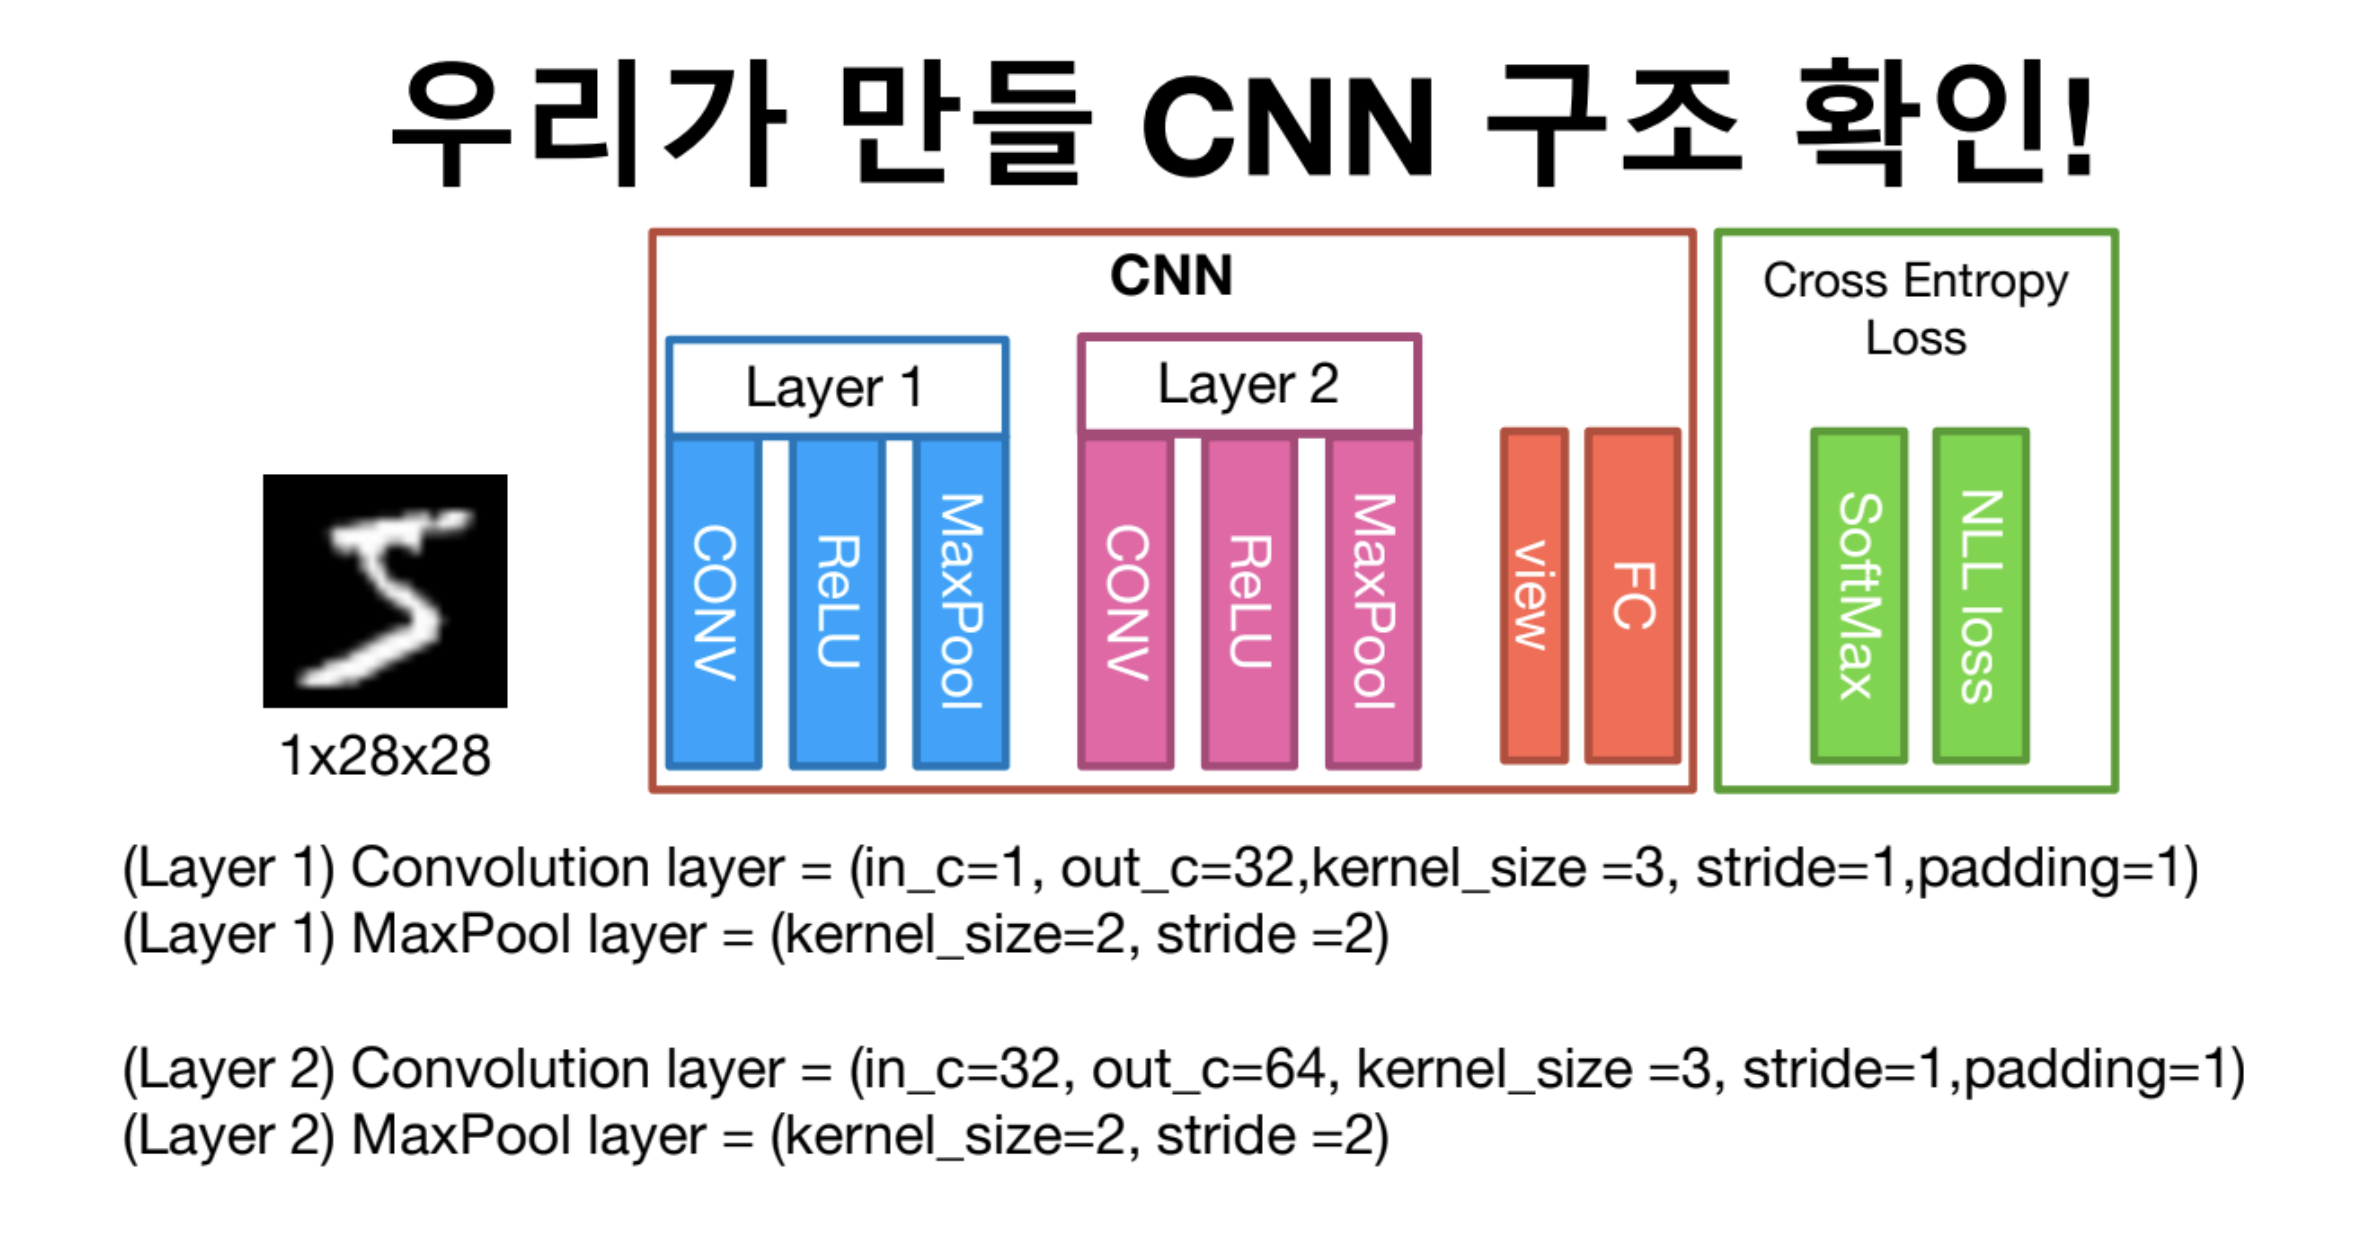

In [3]:
#input
inputs = torch.Tensor(1,1,28,28)
print(inputs.shape)

# layer1
conv1 = nn.Conv2d(1,32,kernel_size= 3, stride= 1, padding=1)
pool = nn.MaxPool2d(2)

outputs = conv1(inputs)
print(outputs.shape)
outputs = pool(outputs)
print(outputs.shape)

#layer2
conv2 = nn.Conv2d(32,64,kernel_size=3, stride=1, padding=1)
outputs = conv2(outputs)
print(outputs.shape)
outputs = pool(outputs)
print(outputs.shape)

# layer3 -> 길게 늘리기
out = outputs.view(outputs.size(0), -1)
print(out.shape)
fc = nn.Linear(3136,10)
out = fc(out)
print(out.shape)


torch.Size([1, 1, 28, 28])
torch.Size([1, 32, 28, 28])
torch.Size([1, 32, 14, 14])
torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 7, 7])
torch.Size([1, 3136])
torch.Size([1, 10])


# 본격적으로 만들어보기

In [4]:
# 1) library 불러오기
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn.init

In [5]:
# 2) device 설정하기
device = "cuda" if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.manual_seed_all(777)

In [6]:
torch.cuda.is_available()

False

In [7]:
# 3) parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [8]:
# 4-1) dataset 가져오기
mnist_train = dsets.MNIST(root = "MNIST_data/", train= True, transform= transforms.ToTensor(), download= True)
mnist_test = dsets.MNIST(root = "MNIST_data/", train= False, transform= transforms.ToTensor(), download= True)

# 4-2) loader 만들기
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset= mnist_train, batch_size= batch_size, shuffle= True, drop_last= True)
test_loader = DataLoader(dataset= mnist_test, batch_size= batch_size, shuffle= False, drop_last= False)


In [9]:
# 5) model 만들기

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.convol = nn.Sequential(
            # layer1
            nn.Conv2d(1,32,kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            #layer2
            nn.Conv2d(32,64,kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            #layer3
            nn.Conv2d(64,128,kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            
            
            # Outputs: 1*128*3*3
        )
        #layer3
        self.fc1 = nn.Linear(3*3*128, 625, bias = True)
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(625, 10, bias = True)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        
        
        
        
    def forward(self,x):
        y_ = self.convol(x)
        y_ = y_.view(y_.size(0),-1)
#         print(y_.shape) --> 이런식으로 shape을 찍어서 debug 가능하다.
        y_ = self.fc1(y_)
        y_ = self.ReLu(y_)
        y_ = self.fc2(y_)
        
        return y_
    
model = CNN().to(device)
print(model)

CNN(
  (convol): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc1): Linear(in_features=1152, out_features=625, bias=True)
  (ReLu): ReLU()
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)


In [10]:
# Debugging을 위해서 이런 방법 사용가능.
test = torch.Tensor(1,1,28,28).to(device)
model(test).shape


torch.Size([1, 10])

In [11]:
# 6) Loss & Optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# make plot

In [12]:
loss_plt = vis.line(Y = torch.Tensor(1).zero_(), opts = dict(title = "loss_tracker", legend = ['loss'], showlegend = True))

In [13]:
# 7) training 
model.train()
total_batch = len(train_loader)
for epoch in range(training_epochs):
    avg_cost = 0
    for X,Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        hypothesis = model(X)
        cost =criterion(hypothesis, Y)
        
        #backward
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        avg_cost += cost.item() / total_batch
        
    print("[Epoch:{:04d}] cost = {:.4f}".format(epoch+1, avg_cost))
    loss_tracker(loss_plt, torch.Tensor([avg_cost]), torch.Tensor([epoch]))
print("Learning Finished!")


[Epoch:0001] cost = 0.1603
[Epoch:0002] cost = 0.0420
[Epoch:0003] cost = 0.0300
[Epoch:0004] cost = 0.0233
[Epoch:0005] cost = 0.0185
[Epoch:0006] cost = 0.0151
[Epoch:0007] cost = 0.0128
[Epoch:0008] cost = 0.0113
[Epoch:0009] cost = 0.0101
[Epoch:0010] cost = 0.0079
[Epoch:0011] cost = 0.0083
[Epoch:0012] cost = 0.0065
[Epoch:0013] cost = 0.0056
[Epoch:0014] cost = 0.0072
[Epoch:0015] cost = 0.0061
Learning Finished!


In [ ]:
with torch.no_grad():
    model.eval()
    X_test = mnist_test.test_data.view(len(mnist_test),1,28,28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    acc = correct_prediction.float().mean()
    print("Accuracy:", acc.item())
    

# 느낀점

- 전체적인 프로세스는 계속 연습해서 점점 익숙해지는 것 같다.
- 추가적인 Regulaization (weight init, dropout, batchnorm)도 추가할 줄 아니까 이정도로 Pass해보자.